<a href="https://colab.research.google.com/github/tirenton/DL_Final/blob/main/DL's_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies

In [ ]:
!pip install yfinance PyPortfolioOpt torch torchvision torchaudio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Load Multi-Asset / Macro Data

In [ ]:
def safe_load(symbol, start="2018-01-01"):
    data = yf.download(symbol, start=start)
    if isinstance(data, pd.DataFrame):
        close_col = data.columns[-1]  # ใช้คอลัมน์สุดท้าย (yfinance auto-adjust)
        return data[close_col].rename(symbol)
    return None

assets = ["BTC-USD", "^GSPC", "GC=F", "^IXIC"]  # Bitcoin, S&P500, Gold, NASDAQ
dfs = [safe_load(sym) for sym in assets]
df = pd.concat(dfs, axis=1).dropna()
print("✅ Data loaded:", df.shape)

/tmp/ipython-input-3788204494.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3788204494.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3788204494.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3788204494.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start)
[*********************100%***********************]  1 of 1 completed

✅ Data loaded: (1970, 4)


*  safe_load(symbol, start)
ดาวน์โหลดราคาย้อนหลังของสัญลักษณ์ที่กำหนดตั้งแต่วันที่ start หากได้ DataFrame จะเลือกคอลัมน์สุดท้าย (โดยปกติมักเป็นราคาปรับแล้ว) แล้วคืนเป็น Series ที่ตั้งชื่อคอลัมน์เท่ากับชื่อสัญลักษณ์ เพื่อเตรียมเอาไปต่อรวมกับตัวอื่นได้สะดวก

*  assets = [...]
รายการสัญลักษณ์ที่ต้องการดึงข้อมูล ได้แก่ BTC-USD, ^GSPC, GC=F, และ ^IXIC

*  dfs = [safe_load(sym) for sym in assets]
เรียก safe_load กับทุกสัญลักษณ์ ได้ลิสต์ของ Series ที่มี index เป็นวันที่เหมือนกันตามช่วงที่ซ้อนทับกัน

*  df = pd.concat(dfs, axis=1).dropna()
นำ Series ทั้งหมดมาต่อเป็นตารางหลายคอลัมน์ตามวันที่ จากนั้นลบแถวที่มีค่าว่างออก เหลือเฉพาะวันที่ที่ทุกสินทรัพย์มีข้อมูลครบพร้อมกัน

## Feature engineering (Multi-asset + Regime)

In [ ]:
import numpy as np
import pandas as pd

# H = horizon วันล่วงหน้า
H = 30
base = df.copy().astype(float)

def rsi_14(x: pd.Series):
    up = x.diff().clip(lower=0).rolling(14, min_periods=14).mean()
    dn = x.diff().clip(upper=0).abs().rolling(14, min_periods=14).mean()
    return 100 - (100/(1 + (up/dn)))

new_features = {}
for c in base.columns:
    price = base[c].replace(0, np.nan)

    with np.errstate(divide="ignore", invalid="ignore"):
        lr = np.log(price/price.shift(1))
    new_features[f"{c}_logret"] = lr.replace([np.inf, -np.inf], np.nan)

    new_features[f"{c}_vol"] = price.pct_change().rolling(14, min_periods=14).std()
    new_features[f"{c}_rsi"] = rsi_14(price)

feat_df = pd.DataFrame(new_features, index=base.index)

# ----- BTC-specific -----
btc = base["BTC-USD"]
feat_df["BTC-USD_ma7"]      = btc.rolling(7,  min_periods=7).mean()
feat_df["BTC-USD_ma21"]     = btc.rolling(21, min_periods=21).mean()
feat_df["BTC-USD_momentum"] = btc / btc.shift(10) - 1
macd_fast = btc.ewm(12, adjust=False).mean()
macd_slow = btc.ewm(26, adjust=False).mean()
macd = macd_fast - macd_slow
feat_df["BTC-USD_macd"]   = macd
feat_df["BTC-USD_signal"] = macd.ewm(9, adjust=False).mean()

# ----- Cross-asset correlations (14D) -----
if all(x in base.columns for x in ["BTC-USD","^GSPC","GC=F","^IXIC"]):
    feat_df["SP500_corr"]  = base["BTC-USD"].rolling(14, min_periods=14).corr(base["^GSPC"])
    feat_df["GOLD_corr"]   = base["BTC-USD"].rolling(14, min_periods=14).corr(base["GC=F"])
    feat_df["NASDAQ_corr"] = base["BTC-USD"].rolling(14, min_periods=14).corr(base["^IXIC"])

# ----- Regime features: 30D realized vol ของ BTC -----
btc_vol30 = btc.pct_change().rolling(30, min_periods=30).std()
feat_df["BTC_vol30"] = btc_vol30
q1, q2 = btc_vol30.quantile([0.33, 0.66])
feat_df["regime_low"]  = (btc_vol30 <= q1).astype(float)
feat_df["regime_mid"]  = ((btc_vol30 > q1) & (btc_vol30 <= q2)).astype(float)
feat_df["regime_high"] = (btc_vol30 > q2).astype(float)

# ----- รวม + target -----
data = pd.concat([base, feat_df], axis=1)
data["target"] = (data["BTC-USD"].shift(-H) > data["BTC-USD"]).astype(int)

# clean
data = data.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
print("✅ Feature table:", data.shape)


✅ Feature table: (1661, 29)


/tmp/ipython-input-1555826659.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  new_features[f"{c}_vol"] = price.pct_change().rolling(14, min_periods=14).std()
/tmp/ipython-input-1555826659.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  new_features[f"{c}_vol"] = price.pct_change().rolling(14, min_periods=14).std()


**RSI-14 ฟังก์ชันเสริม**
*  คำนวณผลต่างรายวัน x.diff() แยกขาขึ้น up และขาลง dn

*  หา average gain/ loss แบบ rolling 14 วัน แล้วนำไปเข้าสูตร RSI (0–100)

**สร้างฟีเจอร์พื้นฐานต่อสินทรัพย์**
*  logret = log-return รายวัน
*  vol = rolling 14D volatility (ส่วนเบี่ยงเบนมาตรฐานของ % change)

*  rsi = RSI-14 จากฟังก์ชันด้านบน

*  รวมเป็น feat_df = DataFrame(new_features, index=base.index)

**ฟีเจอร์เฉพาะ BTC**

*  เส้นค่าเฉลี่ยเคลื่อนที่ 7 และ 21 วัน

*  โมเมนตัม 10 วัน = ผลตอบแทนสะสมช่วง 10 วัน

*  MACD มาตรฐาน (EMA 12 − EMA 26) และเส้นสัญญาณ EMA 9

**Cross-asset correlations (14 วัน)**

*  วัดความสัมพันธ์เชิงเส้นระยะสั้นระหว่าง BTC กับสินทรัพย์หลักอื่นๆ

**Regime features จากความผันผวน 30 วันของ BTC**

*  ใช้ realized vol 30 วันแบ่งเป็น 3 โหมดความผันผวน โดยใช้ quantiles ที่ 33% และ 66%

*  สร้างเป็น one-hot regimes: low / mid / high (ค่า 0/1)

## Prepare dataset (split, scale, sequence)

In [ ]:
from sklearn.model_selection import train_test_split

# เลือกฟีเจอร์ที่สร้างไว้ในด้านบน
feature_keys = ["logret","_vol","_rsi","ma","momentum","macd","signal","_corr","regime_","BTC_vol30"]
features = [c for c in data.columns if any(k in c for k in feature_keys)]

assert "target" in data.columns, "ไม่พบคอลัมน์ target จากขั้นบน"
assert len(features) > 0, "ไม่พบฟีเจอร์จากขั้นบน"

# แยก train/val ตามเวลา (ไม่สลับลำดับ)
split = int(len(data)*0.8)
train_df = data.iloc[:split].copy()
val_df   = data.iloc[split:].copy()

# scale เฉพาะบน train แล้วค่อย transform val เพื่อกัน data leakage
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features]   = scaler.transform(val_df[features])

# ทำเป็น Time Sequence
class SeqDataset(Dataset):
    def __init__(self, frame, fcols, seq_len=128):
        X, y = [], []
        vals = frame[fcols].values
        tars = frame["target"].values.astype(np.float32)
        for i in range(len(frame) - seq_len):
            X.append(vals[i:i+seq_len])
            y.append(tars[i+seq_len])
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

SEQ_LEN = 128
BATCH   = 64
train_loader = DataLoader(SeqDataset(train_df, features, SEQ_LEN), batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(SeqDataset(val_df,   features, SEQ_LEN), batch_size=BATCH, shuffle=False)

print(f"train_size={len(train_df)}  val_size={len(val_df)}  n_features={len(features)}")

train_size=1328  val_size=333  n_features=24


**เลือกฟีเจอร์**

*  เลือกคอลัมน์ฟีเจอร์จาก data ด้วยการแมตช์คำย่อย เช่น *_logret, *_vol, BTC-USD_ma7, macd, *_corr, regime_*, BTC_vol30

**ตรวจความพร้อมของข้อมูล**

* ยืนยันว่ามีคอลัมน์ target และมีฟีเจอร์ให้ใช้

**แบ่งชุดข้อมูลตามเวลา (ป้องกัน leakage)**

* แบ่งแบบเรียงตามเวลา: 80% แรกเป็น train, ที่เหลือเป็น val
(ไม่สลับลำดับ)

**สเกลเฉพาะบน train แล้วค่อยแปลง val**

* fit เฉพาะ train แล้ว transform val เพื่อกัน data leakage

**ทำเป็นลำดับเวลา (window → next label)**

* แต่ละตัวอย่างคือช่วงเวลา [i, i+seq_len-1] และ label คือค่า target ที่เวลา i+seq_len

* สอดคล้องกับนิยาม target ก่อนหน้า (เช่น shift(-H))

**DataLoader**

* train ใช้ shuffle=True เพื่อสุ่มลำดับ batch; val ไม่สุ่ม

## GRU model (regularized)

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, in_dim, hidden=256, layers=3, dropout=0.5):
        super().__init__()
        self.gru = nn.GRU(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.drop = nn.Dropout(dropout)
        self.out  = nn.Linear(hidden, 1)  # binary logit
    def forward(self, x):
        h, _ = self.gru(x)           # (B, T, H)
        h_last = h[:, -1, :]         # (B, H)
        h_last = self.drop(h_last)
        return self.out(h_last)      # (B, 1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = GRUModel(in_dim=len(features), hidden=256, layers=3, dropout=0.5).to(device)

**สถาปัตยกรรม GRUModel**

* ชั้นหลักคือ nn.GRU รับเวกเตอร์ฟีเจอร์ต่อเวลา in_dim

* ซ่อน hidden=256 จำนวนเลเยอร์ layers=3

* dropout ภายใน GRU จะทำงานเฉพาะกรณี layers>1 (ระหว่างเลเยอร์เท่านั้น ไม่ได้ดรอประหว่าง time steps)

* self.drop = nn.Dropout(0.5) หลังดึงสถานะท้ายลำดับ

* self.out = nn.Linear(256, 1) ส่งออก logit ตัวเดียวสำหรับ binary classification

**forward และมิติข้อมูล**
* ใช้ representation ของ timestep สุดท้ายเป็นสรุปลำดับทั้งหมด แล้วแมปเป็น logit เดียว

**การใช้งานกับ loss/metrics**

* เอา logit เข้า BCEWithLogitsLoss โดยตรง (ไม่ต้อง sigmoid ก่อน)

* เวลาประเมินค่า probability ให้ใช้ torch.sigmoid(logit)

## Train / Evaluate utils (Early stopping + Cosine LR)

In [ ]:
def eval_model(model, loader, threshold=0.5):
    model.eval()
    y_true, y_prob, tot = [], [], 0.0
    loss_fn = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logit = model(xb)
            loss  = loss_fn(logit, yb)
            tot  += loss.item()
            prob  = torch.sigmoid(logit).cpu().numpy().ravel()
            y_prob.extend(prob)
            y_true.extend(yb.cpu().numpy().ravel())
    y_true = np.array(y_true); y_prob = np.array(y_prob)
    y_pred = (y_prob > threshold).astype(int)
    # กันเคส all-one/all-zero
    if len(np.unique(y_true)) < 2:
        f1, auc, acc = 0.0, 0.5, (y_pred==y_true).mean()
    else:
        f1  = f1_score(y_true, y_pred, zero_division=0)
        auc = roc_auc_score(y_true, y_prob)
        acc = (y_pred==y_true).mean()
    return tot/len(loader), f1, auc, acc, y_true, y_prob

def train_model(model, train_loader, val_loader, epochs=200, lr=2e-4, patience=10):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(20, epochs//2), eta_min=1e-6)
    loss_fn = nn.BCEWithLogitsLoss()

    best_val = np.inf
    patience_ctr = 0
    history = {"train_loss": [], "val_loss": [], "f1": [], "auc": [], "acc": []}

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logit  = model(xb)
            loss   = loss_fn(logit, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        scheduler.step()

        val_loss, f1, auc, acc, _, _ = eval_model(model, val_loader, threshold=0.5)
        history["train_loss"].append(total/len(train_loader))
        history["val_loss"].append(val_loss)
        history["f1"].append(f1)
        history["auc"].append(auc)
        history["acc"].append(acc)

        print(f"Epoch {ep:03d}: train={total/len(train_loader):.4f}  val={val_loss:.4f}  F1={f1:.3f}  AUC={auc:.3f}  ACC={acc:.3f}")

        # early stopping ตัดสินด้วย val_loss
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            patience_ctr = 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"⏹️ Early stopping at epoch {ep}")
                break

    if 'best_state' in locals():
        model.load_state_dict(best_state)
    return model, history


**eval_model** สลับโมเดลเป็นโหมดประเมินและปิดการคำนวณกราดิเอนต์ จากนั้นวนอ่านข้อมูลเป็นแบตช์ คำนวณลอจิตและ loss แบบ BCEWithLogitsLoss แปลงลอจิตเป็นความน่าจะเป็นด้วย sigmoid แล้วตัดสินคลาสด้วย thresold 05 รวบรวมค่าจริง (y_true) และความน่าจะเป็น (y_prob) เพื่อคำนวณ F1, AUC, ACC และหาค่า loss เฉลี่ย ถ้าป้ายกำกับมีเพียงคลาสเดียวในชุดประเมิน จะกำหนดค่าเริ่มต้นที่ไม่พัง (เช่น AUC=0.5) แล้วส่งคืนผลทั้งหมดพร้อม y_true, y_prob สำหรับใช้วิเคราะห์ต่อ

**train_model** สร้างออปติไมเซอร์ AdamW และตัวลดอัตราเรียนรู้แบบ Cosine Annealing แล้ววนเทรนตามจำนวน epoch ในโหมดฝึก: คำนวณลอจิต, loss, ทำแบ็กพรอพ และอัปเดตพารามิเตอร์ เสร็จหนึ่ง epoch จึงประเมินบนชุดตรวจสอบด้วย eval_model เก็บสถิติ train_loss, val_loss, F1, AUC, ACC และพิมพ์ผล Early Stopping จะเฝ้าดู val_loss ถ้าไม่ดีขึ้นตามเกณฑ์ในช่วง patience จะหยุดก่อนและโหลดพารามิเตอร์ที่ดีที่สุดกลับมา สุดท้ายคืนโมเดลที่ดีที่สุดพร้อมประวัติการเทรน (history)

In [ ]:
print("🔹 Total features selected:", len(features))
print(features[:10], "...")

🔹 Total features selected: 24
['BTC-USD_logret', 'BTC-USD_vol', 'BTC-USD_rsi', '^GSPC_logret', '^GSPC_vol', '^GSPC_rsi', 'GC=F_logret', 'GC=F_vol', 'GC=F_rsi', '^IXIC_logret'] ...


## Train

In [ ]:
# ======================================
# 7) Train
# ======================================
model, history = train_model(model, train_loader, val_loader, epochs=200, lr=2e-4, patience=10)


Epoch 001: train=0.6728  val=0.5501  F1=0.627  AUC=0.758  ACC=0.727
Epoch 002: train=0.6217  val=0.4735  F1=0.611  AUC=0.742  ACC=0.751
Epoch 003: train=0.6068  val=0.4775  F1=0.544  AUC=0.737  ACC=0.722
Epoch 004: train=0.6005  val=0.4633  F1=0.589  AUC=0.751  ACC=0.741
Epoch 005: train=0.5933  val=0.4561  F1=0.544  AUC=0.758  ACC=0.722
Epoch 006: train=0.5825  val=0.4557  F1=0.567  AUC=0.758  ACC=0.732
Epoch 007: train=0.5740  val=0.4439  F1=0.638  AUC=0.775  ACC=0.756
Epoch 008: train=0.5705  val=0.4502  F1=0.645  AUC=0.775  ACC=0.732
Epoch 009: train=0.5497  val=0.4418  F1=0.635  AUC=0.805  ACC=0.702
Epoch 010: train=0.5378  val=0.4384  F1=0.631  AUC=0.797  ACC=0.698
Epoch 011: train=0.5281  val=0.4527  F1=0.620  AUC=0.796  ACC=0.683
Epoch 012: train=0.5202  val=0.4240  F1=0.650  AUC=0.810  ACC=0.722
Epoch 013: train=0.5066  val=0.4506  F1=0.633  AUC=0.789  ACC=0.717
Epoch 014: train=0.5048  val=0.4126  F1=0.707  AUC=0.815  ACC=0.785
Epoch 015: train=0.4984  val=0.4172  F1=0.688  A

## Pick threshold by F1 on validation

In [ ]:
_, _, _, _, y_true_val, y_prob_val = eval_model(model, val_loader, threshold=0.5)

ths = np.linspace(0.2, 0.8, 25)
f1s, accs = [], []
for t in ths:
    pred = (y_prob_val > t).astype(int)
    f1s.append(f1_score(y_true_val, pred, zero_division=0))
    accs.append((pred == y_true_val).mean())

best_idx = int(np.argmax(f1s))
best_th  = float(ths[best_idx])
print(f"Best threshold (F1 on val) = {best_th:.3f}  F1={f1s[best_idx]:.3f}  ACC={accs[best_idx]:.3f}")

Best threshold (F1 on val) = 0.450  F1=0.689  ACC=0.771


## Final validation report + plots

**เกณฑ์วัดผล (Metrics)**
ประเมินผลด้วยสามตัวชี้วัดหลักบนชุดประเมิน
* **Loss** ใช้ BCEWithLogitsLoss ตรวจสอบการลู่เข้าระหว่างเทรนและวาลิเดชัน ถ้าเส้น val loss เริ่มทรงตัวหรือสูงขึ้นขณะ train loss ลดลง แปลว่ามีโอกาสเกิด overfitting
*	**AUC** วัดความสามารถในการจัดอันดับความน่าจะเป็นทิศทางขึ้นลงโดยไม่ยึดติด threshold เหมาะกับชุดข้อมูลที่ class balance อาจไม่เท่ากัน
*	**F1 และ Accuracy** รายงานคู่กัน เพื่อเห็นสมดุล Precision-Recall กับสัดส่วนทายถูกภาพรวม โดย F1 ใช้เมื่อสนใจความคุ้มค่าของสัญญาณที่ยืนยันแล้วมากกว่าแค่เปอร์เซ็นต์ทายถูก


**การเลือกค่าเกณฑ์ตัดสิน (Threshold Selection)**
โมเดลพยากรณ์เป็นความน่าจะเป็นจาก sigmoid บน logit แล้วแปลงเป็นคลาสด้วย threshold ค่าเริ่มต้นที่ 0.5 และทำการกวาดค่าหลายระดับเพื่อหา threshold ที่ให้ F1 สูงสุดบนชุดประเมิน จากนั้นรายงานตัวเลขที่ threshold ดีสุดร่วมกับ AUC ที่ไม่ขึ้นกับ threshold เพื่อความโปร่งใส


**การหยุดก่อนเวลาและการเลือกโมเดล (Model Selection)** ใช้ early stopping โดยยึด val loss เป็นตัวตัดสิน ถ้าไม่ดีขึ้นต่อเนื่องเกิน 10 epochs จะหยุดเทรนและโหลดเวทที่ดีที่สุดกลับมา ช่วยป้องกัน overfitting และลดเวลาเทรนโดยไม่เสียคุณภาพ

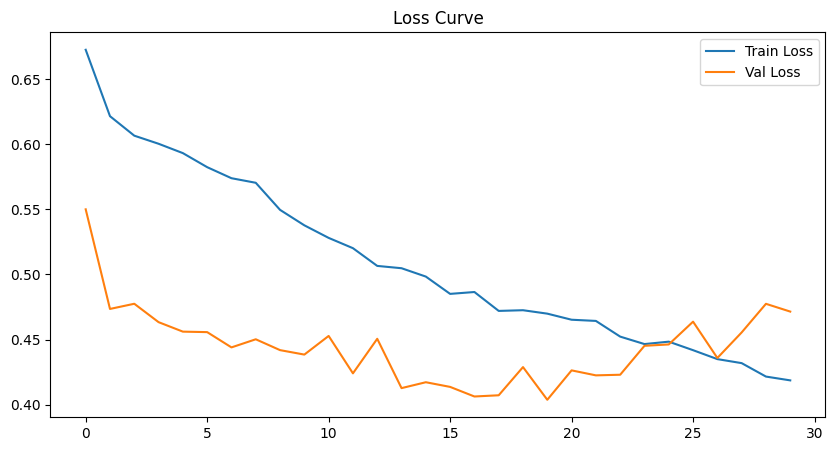

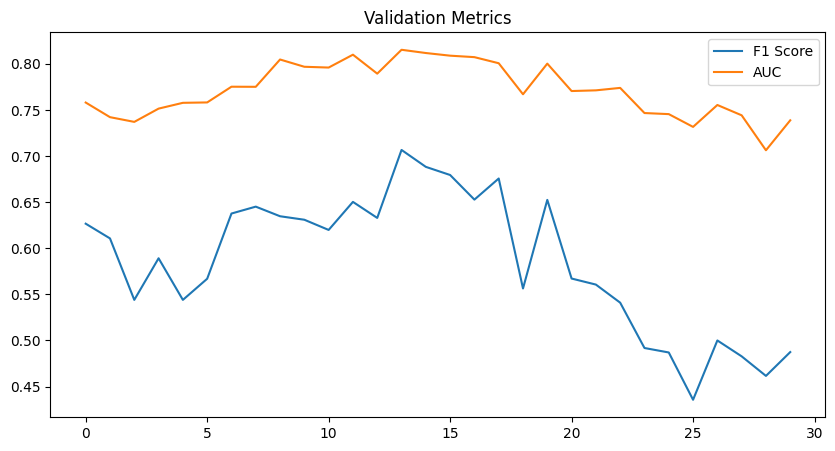

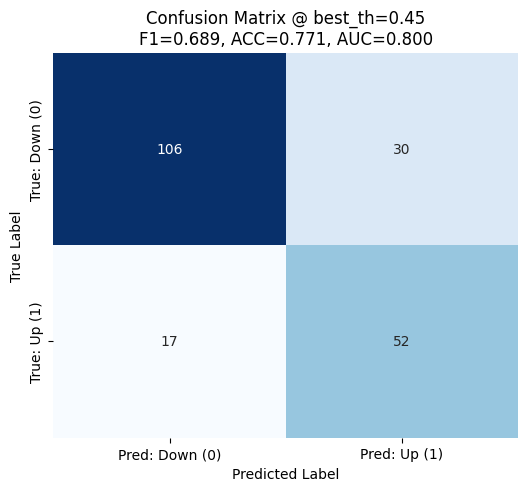

Confusion matrix @ best_th:
 [[106  30]
 [ 17  52]]
Positive ratio (val) = 0.337
Final (val)  AUC=0.800  F1@best_th=0.689  ACC@best_th=0.771


In [ ]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss Curve"); plt.show()

plt.figure(figsize=(10,5))
plt.plot(history["f1"], label="F1 Score")
plt.plot(history["auc"], label="AUC")
plt.legend(); plt.title("Validation Metrics"); plt.show()


# --- Confusion Matrix Visualization ---
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Down (0)', 'Pred: Up (1)'],
            yticklabels=['True: Down (0)', 'True: Up (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix @ best_th={best_th:.2f}\n"
          f"F1={final_f1:.3f}, ACC={final_acc:.3f}, AUC={final_auc:.3f}")
plt.show()

# Confusion matrix at best_th
y_pred_best = (y_prob_val > best_th).astype(int)
cm = confusion_matrix(y_true_val, y_pred_best)
print("Confusion matrix @ best_th:\n", cm)

pos_rate = y_true_val.mean()
print(f"Positive ratio (val) = {pos_rate:.3f}")

# สรุปตัวเลขสุดท้าย @ best_th
final_f1  = f1_score(y_true_val, y_pred_best, zero_division=0)
final_acc = (y_pred_best == y_true_val).mean()
final_auc = roc_auc_score(y_true_val, y_prob_val)
print(f"Final (val)  AUC={final_auc:.3f}  F1@best_th={final_f1:.3f}  ACC@best_th={final_acc:.3f}")

**กราฟและตารางประกอบ (Visualization)**
รายงานกราฟและตารางดังนี้
*  Loss Curves เส้น train loss และ val loss ต่อ epoch เพื่อดูการลู่เข้าและจุดเริ่ม overfit
* Validation Matrix (F1 Score and AUC)
* Confusion Matrix ที่ threshold ดีสุด เห็นจำนวน TP FP TN FN ชัดเจน


**ผลลัพธ์ของตัวที่ดีที่สุด**
ผลลัพธ์โมเดลตัวที่ดีดีที่สุดที่ทำการบันทึกไว้แล้วทำการ Re-Evaluate หลังจากได้ค่า Threshold เพื่อที่จะทำให้ค่า F1 Optimized
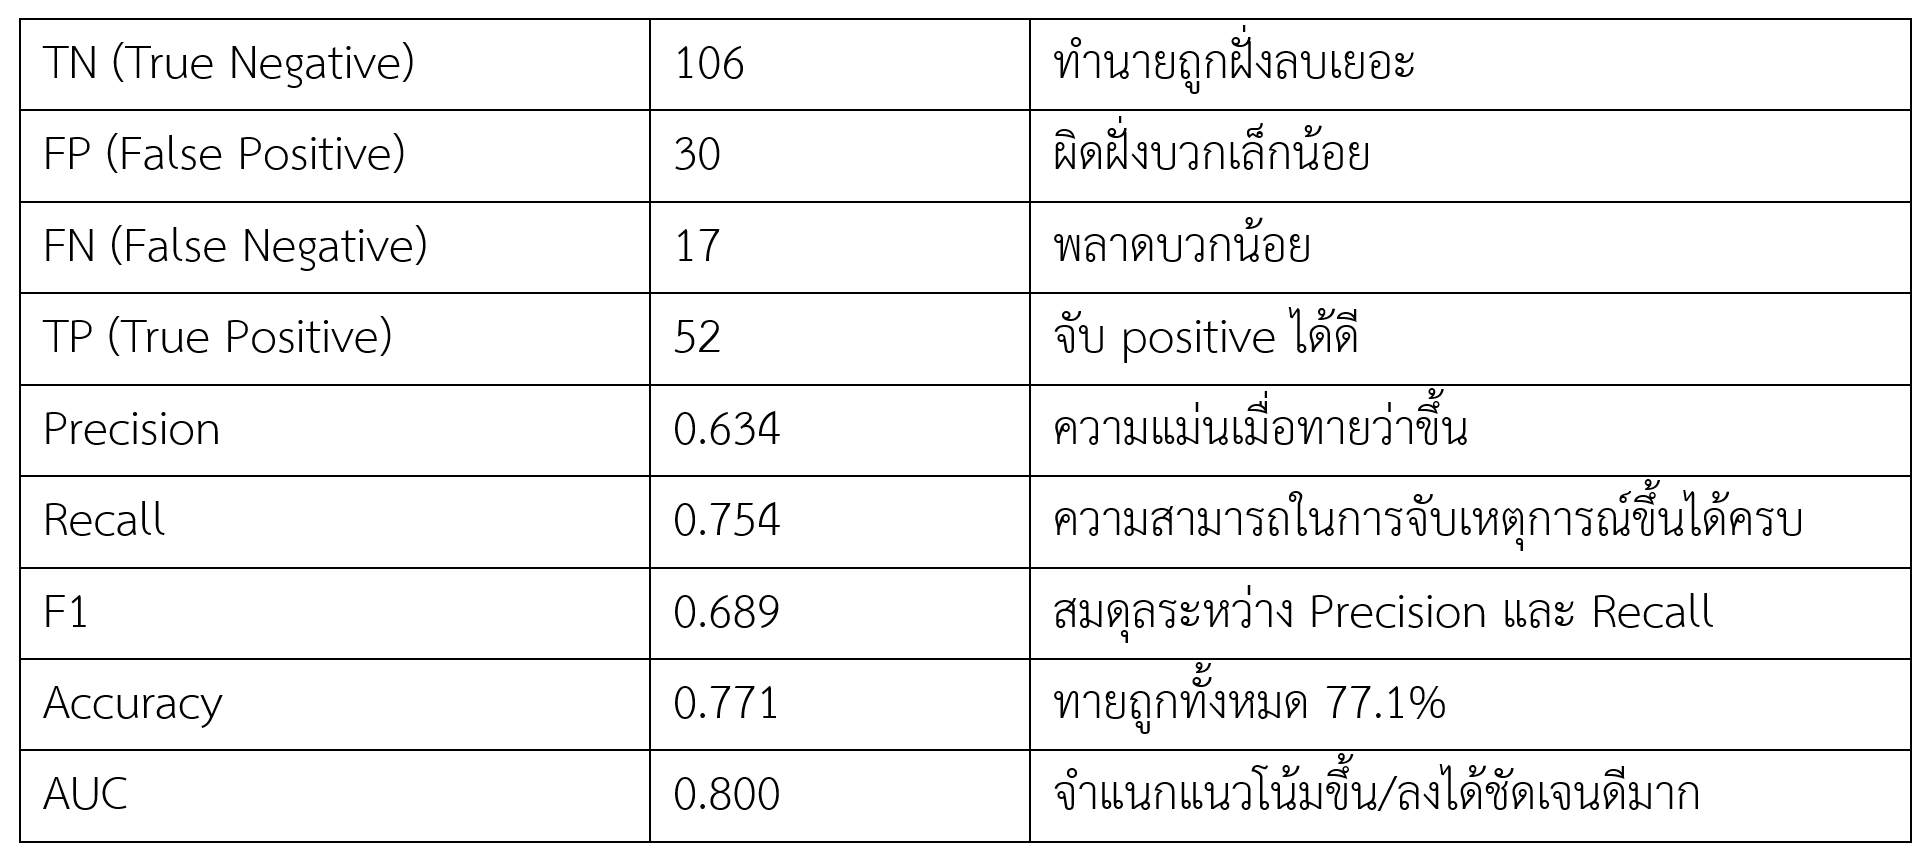